In [1]:
# !pip install torch
# !pip3 install Cython
# !pip3 install sympy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import os
os.getcwd()
if os.getcwd() != '/content/drive/MyDrive/Projects/RBCs_Borealis_AIs_Shelter_Occupancy_Forecast':
  os.chdir('drive/MyDrive/Projects/RBCs_Borealis_AIs_Shelter_Occupancy_Forecast')
os.getcwd()

import pandas as pd
import torch
import plotting as pl
import dataload as dl

DATASET_DIR = 'Datasets'

In [2]:
data_21 = r'{}/daily-shelter-overnight-service-occupancy-capacity-2021.csv'.format(DATASET_DIR)
data_22 = r'{}/daily-shelter-overnight-service-occupancy-capacity-2022.csv'.format(DATASET_DIR)
data_23 = r'{}/daily-shelter-overnight-service-occupancy-capacity-2023.csv'.format(DATASET_DIR)

# data_24 = r"C:\Users\tomng\Desktop\RBC's Borealis AI Lets Solve It\Datasets\Daily shelter overnight occupancy.csv"
# links = [data_24, data_23, data_22, data_21]
links = [data_23, data_22, data_21]

#Weather Data
data_w_21 = r'{}/en_climate_daily_ON_6158355_2021_P1D.csv'.format(DATASET_DIR)
data_w_22 = r'{}/en_climate_daily_ON_6158355_2022_P1D.csv'.format(DATASET_DIR)
data_w_23 = r'{}/en_climate_daily_ON_6158355_2023_P1D.csv'.format(DATASET_DIR)

links_weather = [data_w_23, data_w_22, data_w_21]

#Housing
data_housing = r'{}/Housing.csv'.format(DATASET_DIR)

#Crisis helpline
data_crisis = r'{}/Persons_in_Crisis_Calls_for_Service_Attended_Open_Data.csv'.format(DATASET_DIR)

print(links_weather)

['Datasets/en_climate_daily_ON_6158355_2023_P1D.csv', 'Datasets/en_climate_daily_ON_6158355_2022_P1D.csv', 'Datasets/en_climate_daily_ON_6158355_2021_P1D.csv']


In [3]:
#Load Data takes in all the datasets and create a general dataframe to be adapted again for training different types of Model
dataframe, iso_data = dl.loadData(links, links_weather, data_housing, data_crisis)
#Function output explanation:
#	--DataFrame-- is the general combined data of all datasets, unaltered.
#	--iso_data-- is the dataframe but broken up into a hashmap where the key is the shelter id and the value is the data for that specific shelter

print(dataframe)

df = dl.merge_Shelters_Data(dataframe)
# df = df[['OCCUPANCY_DATE', 'OCCUPIED_PERCENTAGE']]

print(df)
print(iso_data)

# df = dl.prep_Data(dataframe)
# df = df[['OCCUPANCY_DATE', 'OCCUPIED_PERCENTAGE']]
# print(df)

Streaming output truncated to the last 5000 lines.
47900                  11.0                  0.0                3.3   
48031                  13.1                  0.0                4.5   
48162                  16.8                  0.0                0.0   
48297                  17.7                  0.0                2.3   

        Snow on Grnd (cm)  VALUE  Overdose  Person in Crisis  Suicide-related  \
148580                0.0  114.1        11                42               33   
148716                1.0  114.1        32                43               37   
48427                 0.0  114.1        14                48               30   
48563                 3.0  114.1        17                44               26   
48702                 3.0  114.1        14                42               32   
...                   ...    ...       ...               ...              ...   
47769                 0.0  114.6        10                58               26   
47900           

In [ ]:
# df = dl.prep_Data(dataframe)
# print(df)

# uni_headers = ['PROGRAM_ID', 'OCCUPANCY_DATE', 'OCCUPIED_PERCENTAGE']
# df_univariate = df[uni_headers]
# df_univariate['OCCUPANCY_DATE'] = (pd.to_datetime(df_univariate['OCCUPANCY_DATE'])).apply(lambda x: int(x.strftime("%Y%m%d")))
# # df_univariate['OCCUPANCY_DATE'] = df_univariate['OCCUPANCY_DATE'].astype(int) // 10**9  # Convert to Unix timestamp

# multi_headers = ['PROGRAM_ID', 'OCCUPANCY_DATE', 'OCCUPIED_PERCENTAGE']
# df_multivariate = df[multi_headers]
# # df_multivariate['OCCUPANCY_DATE'] = pd.to_datetime(df_multivariate['OCCUPANCY_DATE'])
# # df_multivariate['OCCUPANCY_DATE'] = df_multivariate['OCCUPANCY_DATE'].astype(int) // 10**9  # Convert to Unix timestamp

In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt


# Define your AutoRegressive model
class AutoRegressiveModel(nn.Module):
    def __init__(self, input_size, target_size):
        super().__init__()
        self.linear = nn.Linear(input_size, target_size)

    def forward(self, x):
        predictions = self.linear(x)
        return predictions

class BaseAutoRegressionModel:
  def __init__(self, merged_shelters_data, iso_data, x_headers, y_headers, num_epochs, lr, sequence_input_length, sequence_output_length, batch_size):
    self.x_headers = x_headers
    self.y_headers = y_headers
    self.num_epochs = num_epochs
    self.graph_id = 'All'
    self.lr = lr
    self.sequence_input_length = sequence_input_length
    self.sequence_output_length = sequence_output_length
    self.iso_data = iso_data
    self.merged_shelters_data = merged_shelters_data
    self.batch_size = batch_size

  def shift_by_n(self, X, y, n):
    return X[:-n], y[n:]

  def run_model(self, X, y, graph_id, plotting_occupancy = True, turn_off_print = False):
    assert len(X) == len(y)
    print("Starting training")
    # num_samples = 1000
    # sequence_length = 10

    print("--------- DATA SPLITTING ---------")
    # Split the data into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    print("--------- CONVERTAIN DATA TO TENSORS ---------")
    # Convert DataFrame to PyTorch tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

    print("--------- CREATE DATALOADERS ---------")
    # Create DataLoader for training, validation, and test sets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)

    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

    print("--------- RETRIEVING INPUT SIZE AND TARGET SIZE ---------")
    input_size = X_train_tensor.size(1)
    target_size = y_train_tensor.size(1)
    print("Input size: {}, target size: {}".format(input_size, target_size))

    print("--------- INSTANTIATE AUTOREGRESSIVE MODEL ---------")
    # Instantiate the AutoRegressive model
    model = AutoRegressiveModel(input_size=input_size, target_size=target_size)

    print("--------- INSTANTIATE OPTIMIZER AND CRITERION ---------")
    print('Model params: {}'.format(model.parameters()))
    # Training loop
    optimizer = torch.optim.Adam(model.parameters(), lr=self.lr)
    criterion = nn.MSELoss()

    print("--------- TRANING AND VALIDATION ---------")

    for epoch in range(self.num_epochs):
        # Training
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                val_loss = criterion(outputs, targets)
                val_losses.append(val_loss.item())
        avg_val_loss = sum(val_losses) / len(val_losses)
        print(f"Epoch {epoch+1}/{self.num_epochs}, Validation Loss: {avg_val_loss:.4f}") if not turn_off_print else None

    # Testing
    model.eval()
    test_losses = []
    date = []
    real = []
    predicted = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            test_loss = criterion(outputs, targets)
            test_losses.append(test_loss.item())

            # Convert tensors to numpy arrays and flatten them
            inputs_np = (inputs.squeeze() * 10**9 ).numpy().tolist()
            targets_np = targets.squeeze().numpy().tolist()
            outputs_np = outputs.squeeze().numpy().tolist()

            # Extend lists with data from the current batch
            date.extend(inputs_np)
            real.extend(targets_np)
            predicted.extend(outputs_np)

    avg_test_loss = sum(test_losses) / len(test_losses)
    print(f"Test Loss: {avg_test_loss:.4f}")

    return model, real, predicted, loss, val_losses, test_losses

  def plot_results_against_all_shelters(self):
    combined_df = self.merged_shelters_data

    X = combined_df[self.x_headers]
    y = combined_df[self.y_headers]
    X, y = self.shift_by_n(X, y, 1)

    output = self.run_model(X, y, 'all', True, True)
    model = output[0]
    val_losses = output[4]
    test_losses = output[5]

    self.plot_general(val_losses, test_losses, 'All', 'Sample Index', 'Value', 'Validation Losses', 'Test Losses')

    return model

  def test_combined_model(self, num_future_preds, num_shelters_plot = 0, plotting_occupancy = True, turn_off_print = False, specified_shelters = None):

      model = self.plot_results_against_all_shelters()

      if specified_shelters:
        shelters = specified_shelters
      else:
        shelters = self.unique_shelters[:num_shelters_plot+1]

      if plotting_occupancy:
        print("--------- Plotting predictions vs target ---------")

        shelter_predictions = []
        for i in shelters:
          graph_id = i
          df = self.iso_data[graph_id]
          if df['OCCUPANCY_RATE_ROOMS'].isna().all():
            df = df.rename(columns = {'OCCUPANCY_RATE_BEDS': 'OCCUPIED_PERCENTAGE'})
          else:
            df = df.rename(columns = {'OCCUPANCY_RATE_ROOMS': 'OCCUPIED_PERCENTAGE'})

          X = df[self.x_headers]
          y = df[self.y_headers]
          X, y = self.shift_by_n(X, y, 1)

          # Convert DataFrame to PyTorch tensors
          X_tensor = torch.tensor(X.values, dtype=torch.float32)
          y_tensor = torch.tensor(y.values, dtype=torch.float32)

          # Create DataLoader for the entire dataset
          dataset = TensorDataset(X_tensor, y_tensor)

          loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)

          predictions = []
          with torch.no_grad():
            for inputs, targets in loader:
              outputs = model(inputs)
              predictions.extend(outputs.numpy().tolist())

            for i in range(num_future_preds):
              inputs = torch.tensor([predictions[-32:-1]], dtype=torch.float32) # make predictions based on the last prediction
              # X_tensor = torch.tensor(predictions[-1], dtype=torch.float32)
              outputs = model(inputs)
              outputs = torch.tensor([[outputs[-1][-1]]], dtype=torch.float32)
              predictions.extend(outputs.numpy().tolist())

          # shelter_predictions.append(np.mean(predictions))

          self.plot_general(y.values, predictions, graph_id, 'Sample Index', 'Value', 'Target', 'Predictions')
        # print(np.mean(shelter_predictions))

  #Inferring Data for All Shelters
  def plot_general(self, real, predicted, id, x_label, y_label, label_1, label_2):

    # Plotting
    plt.figure(figsize=(10, 6))
    if len(real) != 0:
      plt.plot(real, label=label_1, marker='o')
    plt.plot(predicted, label=label_2, marker='x')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title('{} vs {} Target for Shelter {}'.format(label_1, label_2, id))
    plt.legend()
    plt.show()



97.32787761744987
Starting training
--------- DATA SPLITTING ---------
--------- CONVERTAIN DATA TO TENSORS ---------
--------- CREATE DATALOADERS ---------
--------- RETRIEVING INPUT SIZE AND TARGET SIZE ---------
Input size: 1, target size: 1
--------- INSTANTIATE AUTOREGRESSIVE MODEL ---------
--------- INSTANTIATE OPTIMIZER AND CRITERION ---------
Model params: <generator object Module.parameters at 0x7a561ec674c0>
--------- TRANING AND VALIDATION ---------
Test Loss: 0.0731


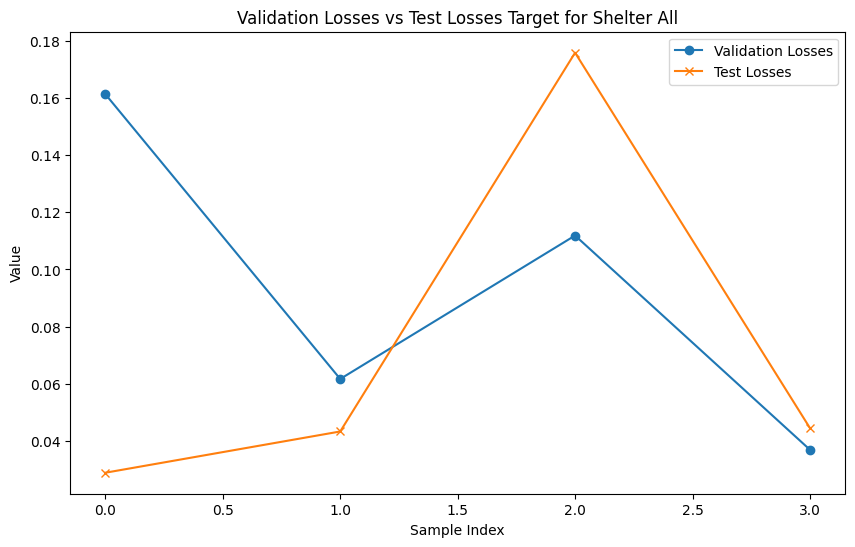

--------- Plotting predictions vs target ---------


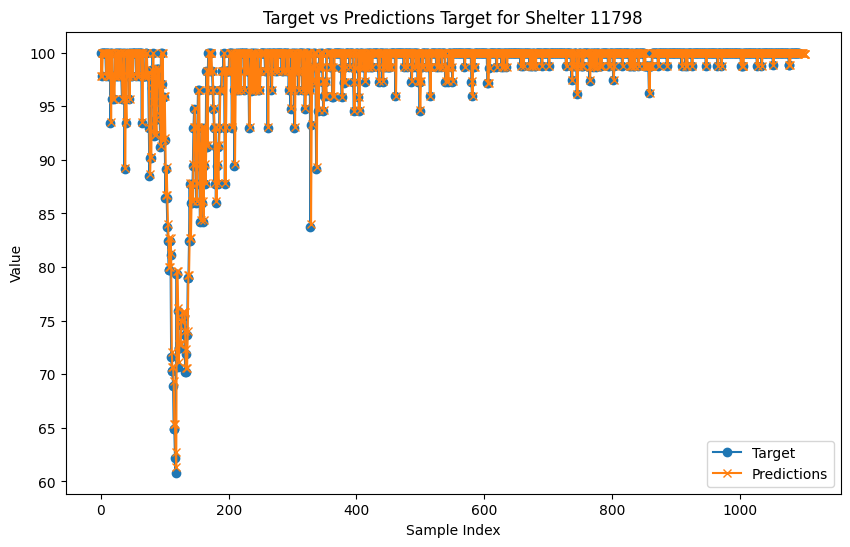

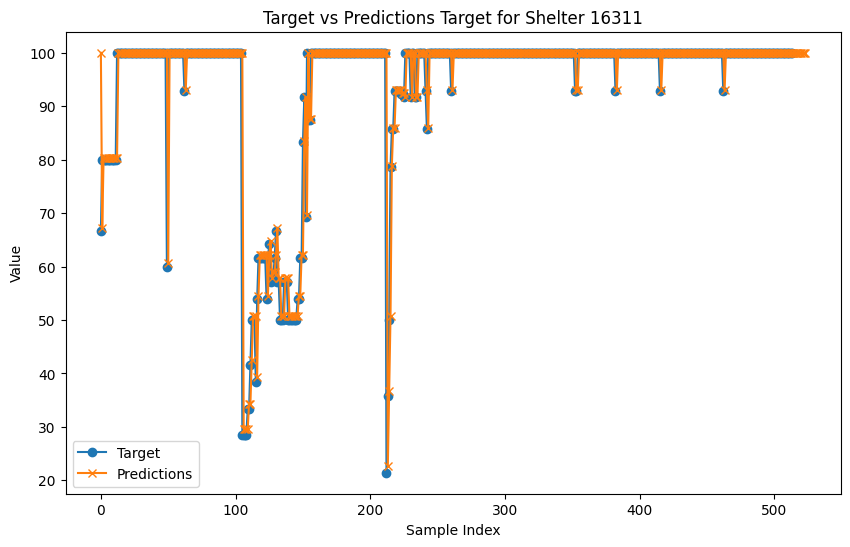

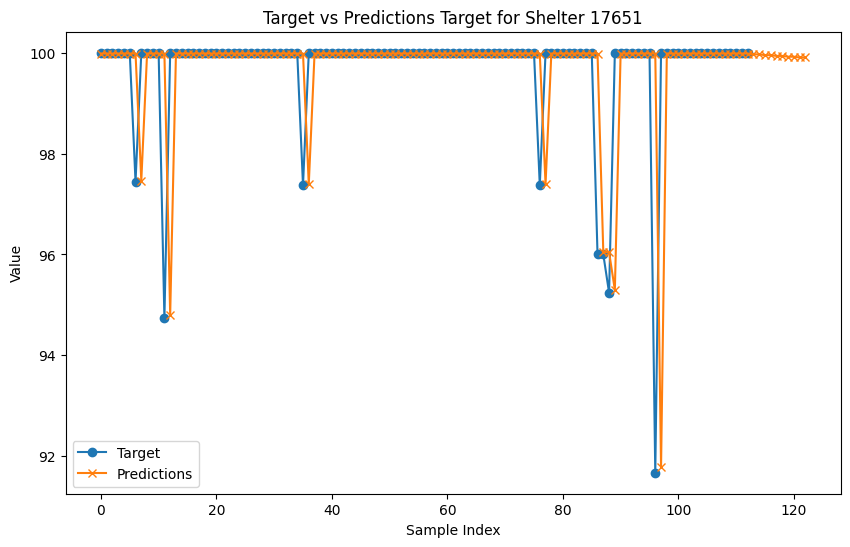

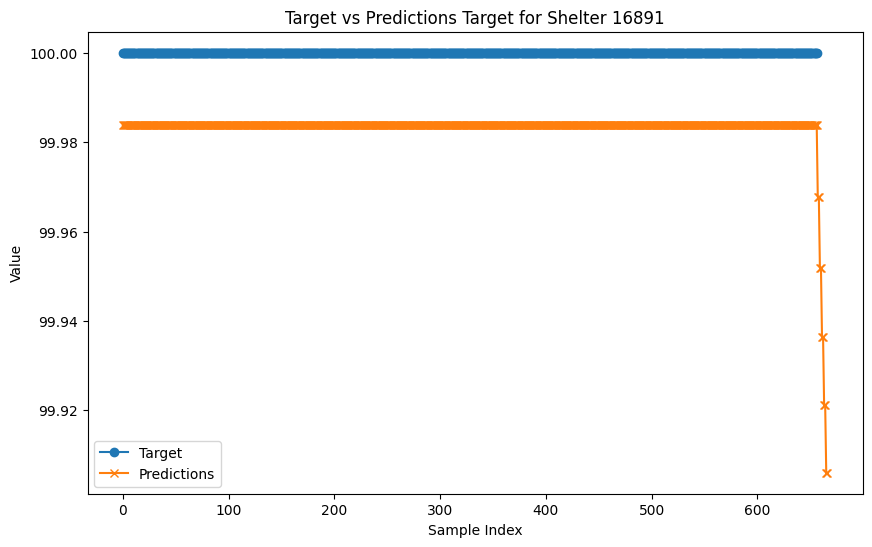

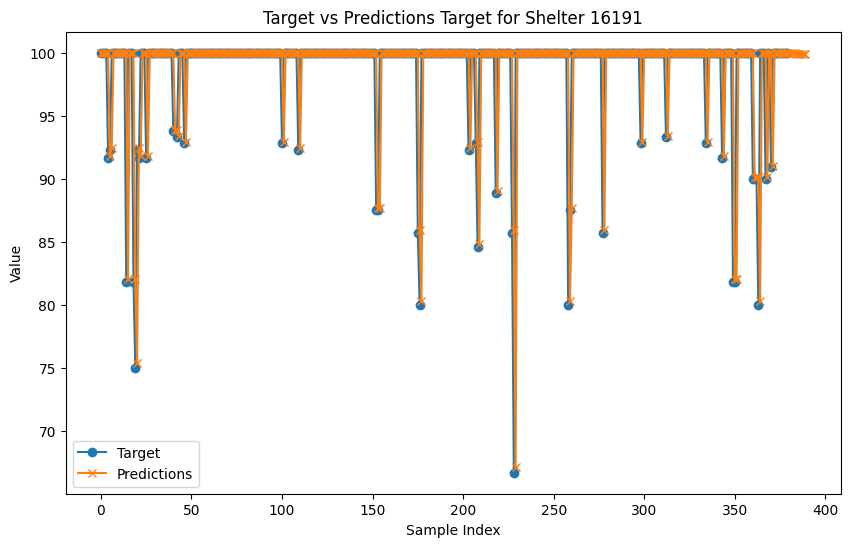

In [5]:
uni_model = BaseAutoRegressionModel(df, iso_data, ['OCCUPIED_PERCENTAGE'], ['OCCUPIED_PERCENTAGE'], 100, 0.01, 5, 5, 32)
print(df['OCCUPIED_PERCENTAGE'].mean())
uni_model.test_combined_model(10, num_shelters_plot = 0, plotting_occupancy = True, turn_off_print = False, specified_shelters = [11798, 16311, 17651, 16891, 16191])
# uni_model.test_combined_model(50, num_shelters_plot = 0, plotting_occupancy = True, turn_off_print = False, specified_shelters = [16191])
# uni_model.run_model_on_each_shelter(10, True, True, specified_shelters = [11798, 16311, 17651, 16891, 16191])
